# Phenopacket store statistics

This notebook performs quality assessment and calculate descriptive statistics about a phenopacket-store release. 

In [1]:
import math

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

The input file is the ZIP file that is or will be added to each release.

The ZIP file can be generated by running:

```shell
python3 -m ppktstore package --notebook-dir notebooks --output all_phenopackets
```

assuming `ppktstore` has been installed into the active environment, and `notebooks` points to the folder with Phenopacket store notebook directory.

In [2]:
from ppktstore.model import PhenopacketStore

input_zip = 'all_phenopackets.zip'
store = PhenopacketStore.from_release_zip(input_zip)

Now we can summarize statistics of the individuals described in the phenopackets, their phenotypic features, diseases, and genotypes.

In [3]:
from ppktstore.stats import PPKtStoreStats

stats = PPKtStoreStats(store)

The summary 

In [4]:
df = stats.get_summary_df().sort_values(by='gene')
df.head()

,patient_id,cohort,disease_id,disease,gene,allele_1,allele_2,PMID,filename
69,Family 2 proband,AAGAB,OMIM:148600,"Keratoderma, palmoplantar, punctate type IA",AAGAB,NM_024666.5:c.473del,,PMID:28239884,all_phenopackets.zip/0.1.16/AAGAB/PMID_28239884_Family2proband.json
70,Family 1 proband,AAGAB,OMIM:148600,"Keratoderma, palmoplantar, punctate type IA",AAGAB,NM_024666.5:c.505_506dup,,PMID:28239884,all_phenopackets.zip/0.1.16/AAGAB/PMID_28239884_Family1proband.json
71,Family 3 proband,AAGAB,OMIM:148600,"Keratoderma, palmoplantar, punctate type IA",AAGAB,NM_024666.5:c.870+1G>A,,PMID:28239884,all_phenopackets.zip/0.1.16/AAGAB/PMID_28239884_Family3proband.json
72,II.2,ABCA4,OMIM:601718,Retinitis pigmentosa 19,ABCA4,NM_000350.3:c.1938-1G>A,,PMID:10874631,all_phenopackets.zip/0.1.16/ABCA4/PMID_10874631_II2.json
74,IV.13,ABCB7,OMIM:301310,"Anemia, sideroblastic, and spinocerebellar ataxia",ABCB7,NM_001271696.3:c.1200T>G,,PMID:4045952,all_phenopackets.zip/0.1.16/ABCB7/PMID_4045952_IV13.json


## Individual statistics

In [5]:
from ppktstore.stats import summarize_individuals

individuals_df = summarize_individuals(store)
individuals_df.head(2)

,id,sex,age_in_days,age_in_years,vital_status
0,PMID_15266616_35-35,MALE,1095.75,3.0,None
1,PMID_15266616_148-148,FEMALE,NaN,NaN,None


### Summary statistics

The number of males and females in all case report collections.

The number and percentage of subjects with the age information available.

In [6]:
n_no_age = sum(individuals_df.age_in_days.isna())
n_w_age = len(individuals_df) - n_no_age
individuals_summary = {
    'males': sum(individuals_df.sex=='MALE'),
    'females': sum(individuals_df.sex=='FEMALE'),
    'individuals with no age': f'{n_no_age} ({n_no_age * 100 / len(individuals_df):.1f}%)',
    'individuals with age': f'{n_w_age} ({n_w_age * 100 / len(individuals_df):.1f}%)',
}
individuals_summary

{'males': 2347,
 'females': 2071,
 'individuals with no age': '2281 (38.0%)',
 'individuals with age': '3717 (62.0%)'}

### Age at last encounter

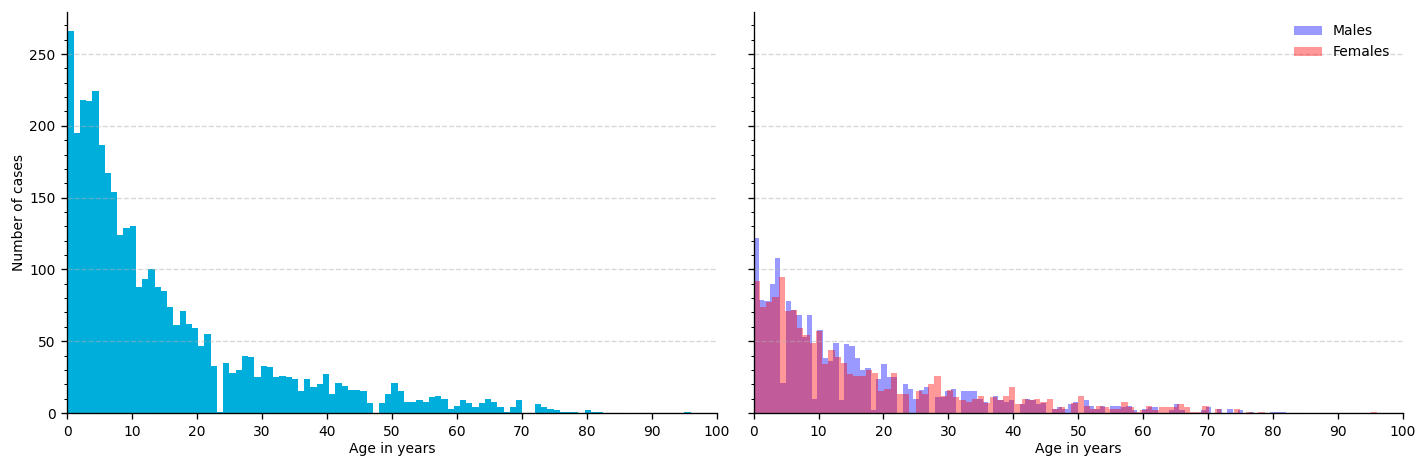

In [7]:
fig, (l, r) = plt.subplots(1, 2, figsize=(12, 4), dpi=120, sharey=True,)

# round up to nearest 10
xmax = math.ceil(math.ceil(max(individuals_df.age_in_years)) / 10) * 10
l.hist(
    individuals_df.age_in_years, bins=xmax, 
)

l.set(
    xlabel='Age in years', xlim=(0, xmax),
    ylabel='Number of cases', 
)
l.xaxis.set(major_locator=mpl.ticker.MultipleLocator(10))
l.yaxis.set(minor_locator=mpl.ticker.MultipleLocator(10))
l.grid(axis='y')

r.hist(
    individuals_df.loc[individuals_df.sex == 'MALE', 'age_in_years'], bins=xmax, 
    color='blue', alpha=.4, label='Males',
)
r.hist(
    individuals_df.loc[individuals_df.sex == 'FEMALE', 'age_in_years'], bins=xmax, 
    color='red', alpha=.4, label='Females',
)

r.legend()
r.set(
    xlabel='Age in years', xlim=(0, xmax),
)
r.xaxis.set(major_locator=mpl.ticker.MultipleLocator(10))
r.grid(axis='y')

fig.tight_layout()
fig.savefig("age_dist.pdf")
fig.savefig("age_dist.png")

In [8]:
stats_d = stats.get_descriptive_stats()
items = list()
for k,v in stats_d.items():
    items.append({"item": k, "value": v})
pd.DataFrame(items)


,item,value
0,version,0.1.17.dev0
1,phenopackets,5998
2,diseases,467
3,genes,414
4,alleles,3555
5,PMIDs,859
6,individuals per gene (max),463
7,individuals per gene (min),1
8,individuals per gene (mean),14.487923
9,individuals per gene (median),4.0


## Phenotypic features

Show how many phenotypic features include age of onset info.

First, count the phenotypic features, and the features where the `onset` is available.

In [9]:
from collections import defaultdict, Counter

count = defaultdict(Counter)
total = Counter()

for cohort in store.cohorts():
    for pp_info in cohort.phenopackets:
        for pf in pp_info.phenopacket.phenotypic_features:
            total[cohort.name] += 1
            element = pf.onset.WhichOneof('element')
            if element is not None:
                count[element][cohort.name] += 1

total_df = pd.Series(total, name='total')

onset_df = (
    pd.DataFrame(count)
    .join(total_df, how="outer")
    .fillna(0)
    .astype({"age": int, "ontology_class": int, "total": int})
)
onset_df.head(2)

,age,ontology_class,total
11q_terminal_deletion,0,0,4401
AAGAB,3,0,12


In [10]:
have_onset = onset_df[['age', 'ontology_class']].sum().sum()
n_total_pf = onset_df['total'].sum()
perc = 100 * have_onset / n_total_pf
print(f'{have_onset:,} of the total of {n_total_pf:,} ({perc:.2f}%) phenotypic features had an associated age of onset.')

4,479 of the total of 104,828 (4.27%) phenotypic features had an associated age of onset.


## Disease stats

Summary statistics of disease diagnoses per case report collection:

In [11]:
disease_by_cohort = df[['cohort', 'disease_id']].drop_duplicates().groupby('cohort').size()
disease_by_cohort.agg(['mean', 'median', 'min', 'max'])

mean      1.133172
median    1.000000
min       1.000000
max       7.000000
dtype: float64

Distribution of number of cases per disease.

In [12]:
counts_per_disease = stats.get_counts_per_disease_df()
counts_per_disease.head(2)

,disease,count
0,OMIM:147791,69
1,OMIM:148600,3


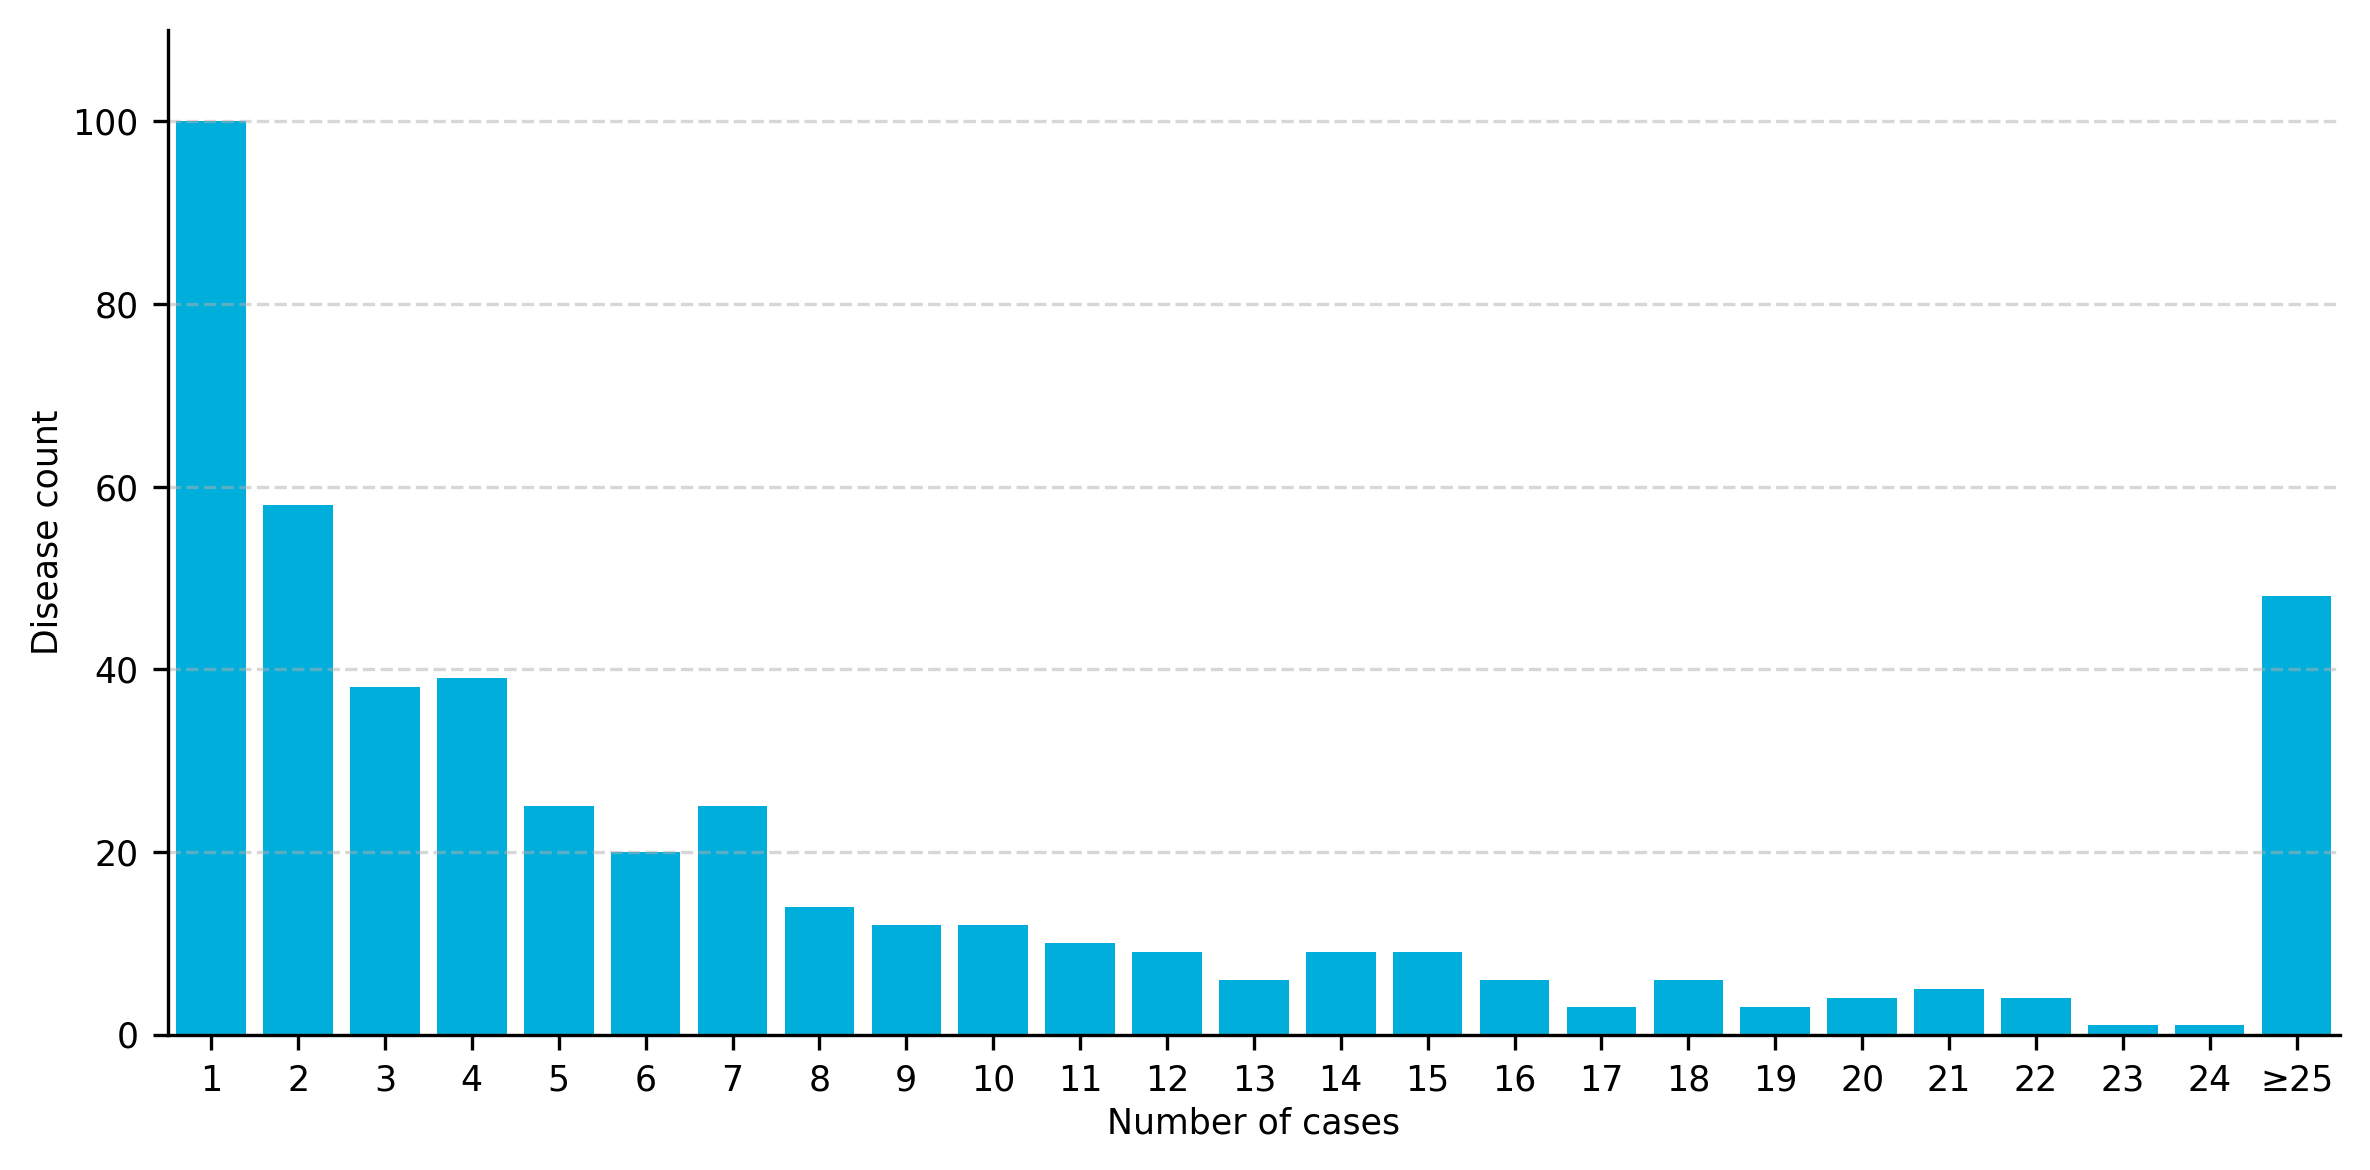

In [13]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=300)

disease_counts = counts_per_disease["count"]
max_val = 25

assert (
    isinstance(max_val, int) and max_val > 0
), "`max_val` must be a positive `int`"

bins = list(range(1, max_val + 1)) + [disease_counts.max() + 1]
labels = list(map(str, bins[:-2])) + [f"≥{max_val}"]
cats = pd.cut(
    x=disease_counts,
    bins=bins,
    labels=labels,
    right=False,
)
cat_count = cats.value_counts().sort_index()
ax.bar(x=cat_count.index, height=cat_count.values)
ax.set(
    xlabel="Number of cases", xlim=(-0.5, len(labels) - 0.5),
    ylabel="Disease count", ylim=(0, 110),
)
ax.xaxis.set(major_locator=mpl.ticker.MultipleLocator(1))
ax.grid(axis="y")
ax.spines['top'].set(visible=False)
ax.spines['right'].set(visible=False)

fig.tight_layout()

## Gene stats

Compute the counts of cases associated with mutations in a gene per case report collection.

In [14]:
disease_by_cohort = df[['cohort', 'gene']].drop_duplicates().groupby('gene').size()
disease_by_cohort.agg(['mean', 'median', 'min', 'max'])

mean      1.0
median    1.0
min       1.0
max       1.0
dtype: float64

## Allele stats

Compute the counts of distinct alleles per case report collection:

In [15]:
df[['cohort', 'allele_1', 'allele_2']].head(2)

,cohort,allele_1,allele_2
69,AAGAB,NM_024666.5:c.473del,
70,AAGAB,NM_024666.5:c.505_506dup,


In [16]:
uniq_alleles_by_cohort = (
    df[['cohort', 'allele_1', 'allele_2']]
    .melt(
          id_vars=['cohort'], var_name='which', 
          value_name='allele', value_vars=['allele_1', 'allele_2'],
    )
    .drop(columns=['which'])
    # .sort_values(by=['cohort', 'allele'])
    .loc[lambda row: row.allele != '']
    .drop_duplicates()
    .groupby(['cohort']).size()
)
uniq_alleles_by_cohort.head(2)

cohort
11q_terminal_deletion    1
AAGAB                    3
dtype: int64

In [17]:
uniq_alleles_by_cohort.agg(['mean', 'median', 'min', 'max'])

mean        8.723971
median      3.000000
min         1.000000
max       264.000000
dtype: float64

## Publication statistics

How many publications were used to prepare a case report collection.

In [18]:
pmid_by_cohort = df[['cohort', 'PMID']].drop_duplicates().groupby('cohort').size()
pmid_by_cohort.agg(['mean', 'median', 'min', 'max'])

mean       2.101695
median     1.000000
min        1.000000
max       25.000000
dtype: float64

# Q/C checks

## Check all disease identifiers
They should all be CURIEs with the prefixes OMIM or MONDO. There should be no whitespace between the colon and the suffix.

In [19]:
_ = stats.check_disease_id()

No problems found.


## Check for duplicates
In some cases, duplicate phenopackets were inadvertently added to some of the initial cohorts at earlier stages of the project. This function lists phenopacket identifers arranged according to variant and allows us to more easily check for this kind of error.

## Other checks

In [20]:
_ = stats.show_possible_duplicates_by_variant("ERI1")

No candidate duplicates found for ERI1


In [21]:
_ = stats.find_phenopackets_with_no_variants()

All phenopackets had at least one variant


In [22]:
_ = stats.show_possible_duplicates_by_variant( "ARPC5")

No candidate duplicates found for ARPC5


In [23]:
_ = stats.find_phenopackets_with_no_disease()

All phenopackets had a disease diagnosis


*-* EOF *-*